In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install pyod

     |████████████████████████████████| 102kB 3.2MB/s 
     |████████████████████████████████| 2.1MB 9.3MB/s 
  Created wheel for pyod: filename=pyod-0.7.8.2-cp36-none-any.whl size=104997 sha256=dc5233739ac628fdd604ac5952c60b632533fd97f777c98dc94b089a7f4eaf6f
  Stored in directory: /root/.cache/pip/wheels/28/38/ec/0ecbcd67faeb595ac0dbd9b5f85d5c5bdcb4573819e65240fe
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=fd450c5211f4d5f0974359a59f598cacc26d9985d0dbcf9ef7fc81e9b470703a
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=01cc4f0c485890a6ea137b545239436ee31f92f85851d18f57edb0163761c771
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [0]:
!pip install tsfresh

     |████████████████████████████████| 81kB 2.5MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=21f52f4c17cd4523c98a7ab85c1686cb5858aaf3b8674724b3ca4f30d3c6e536
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [0]:
!pip install PyWavelets

In [0]:
import pandas as pd
import numpy as np
#import pyod
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models import cblof, knn, lof
from pyod.models.feature_bagging import FeatureBagging
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from pyod.models.auto_encoder import AutoEncoder
from statsmodels.tsa.arima_model import ARIMA
from sklearn.svm import OneClassSVM
import statsmodels.api as sm
from math import factorial, log
from itertools import groupby
from scipy.signal import periodogram, welch
from tsfresh.feature_extraction.feature_calculators import longest_strike_above_mean, first_location_of_maximum, first_location_of_minimum, c3
from tsfresh.feature_extraction.feature_calculators import mean_second_derivative_central, sample_entropy, skewness, cid_ce, number_crossing_m
from tsfresh.feature_extraction.feature_calculators import percentage_of_reoccurring_datapoints_to_all_datapoints, kurtosis
import pywt
from keras.models import Model
from keras.layers import Input, Dense

# Syhthèse des travaux effectués

## 1. Introduction

L'objectif de ce Data Challenge a été de développer un algorithme permettant de détecter les anomalies d'un jeu de données.

L'ensemble des données est fourni par Airbus et consiste en des mesures de l'accéléromètre des hélicoptères pendant 1 minute à la fréquence 1024 Hertz, ce qui donne des séries temporelles mesurées à un total de 60 * 1024 = 61440 points équidistants.

Au delà de l'algorithme utilisé pour détecter les outliers, toute la difficulté du projet a été de préparer les données et de restructurer le dataset : je me suis tout particulièrement concentrée sur la feature extraction et la création de nouvelles caractéristiques.

## 2. Les différentes tentatives de détection explorées mais non retenues

En partant de la solution initiale proposée (PCA + LOF), j'ai essayé différentes techniques pour améliorer cette première solution.

### 2.1. Feature Extraction

Tout d'abord, j'ai souhaité remplacer la PCA par un autoencodeur pour jouer le rôle de réduction de matrice. Ceci n'a pas été concluant, j'ai donc laissé de côté cette méthode.

Je me suis également intéressée de près à la décomposition des time series par Fourier ou ondelettes (wavelates). J'ai donc essayé de de retravailler le dataset en décomposant les signaux par STL : les performances n'étaient pas mauvaises, mais cette décomposition ne m'a permis d'améliorer mon modèle.

Aussi, j'ai testé la création de différentes features permettant de décrire les sigaux, telles que la moyenne, la médiane, les forces de la saisonnalité et de la tendance, etc. J'ai ensuite appliqué une PCA sur ces différentes features calculées. La séléction par PCA n'a pas été concluante, j'ai donc effectué une séléction plus manuelle des différente features à créer.

### 2.2. Algorithmes

Une fois les données préparées, j'ai essayé plusieurs algorithmes, provenant de différentes librairies (scikit, PyOD) : SVM, Isolation Forest, KNN, LOF. Il s'est averé que parmi tous mes essais, le LOF m'a donné les meilleurs résultats.

Aussi, j'ai essayé de moyenner les scores obtenus via plusieurs algorithmes : ceci n'a pas été concluant.

## 3. La solution retenue

J'ai obtenu les meilleurs résultats en procédent de la façon suivante : 

### 3.1. Feature Extraction

- Calcul de statistiques descriptives et de nouvelles features : 
  - moyenne du signal d'une observation, min, max, std, variance, percentiles
  - autocorrélation du 1er ordre
  - forces de la saisonnalité et de la tendance
  - premier emplacement de la valeur maximale du signal
  - c3 : mesure de la non-linéarité du signal
  - valeur moyenne d'une approximation centrale de la dérivée seconde

- Réduction de dimensions de la matrice initiale
  - Moyenner par fenêtre mobile les points d'une observation (par fenêtre de 32)
  - Appliquer une PCA sur la matrice réduite

### 3.2. Algorithmes

Une fois les données préparées, j'ai appliqué un Bagging de 500 LOF avec la librairie PyOD.

## 4. Les axes d'amélioration

La décomposition des signaux par Fourier me semblait intéressante, j'ai malheureusement testé cette solution un peu tard, et je n'ai pas pu suffisement la creuser. Avec plus de temps, j'aurais aimé poursuivre l'exploration de cette piste.

# Import des données

In [0]:
xtrain = np.loadtxt('/content/gdrive/My Drive/TELECOM_MS/TELECOM/P3/MDI341/data_challenge/airbus_train.csv', delimiter= ' ')
print(xtrain.shape)
xtest = np.loadtxt('/content/gdrive/My Drive/TELECOM_MS/TELECOM/P3/MDI341/data_challenge/airbus_test.csv', delimiter= ' ')
print(xtest.shape)

(1677, 61440)
(2511, 61440)


In [0]:
X_train = pd.DataFrame(xtrain)
X_test = pd.DataFrame(xtest)

# Exploration de données

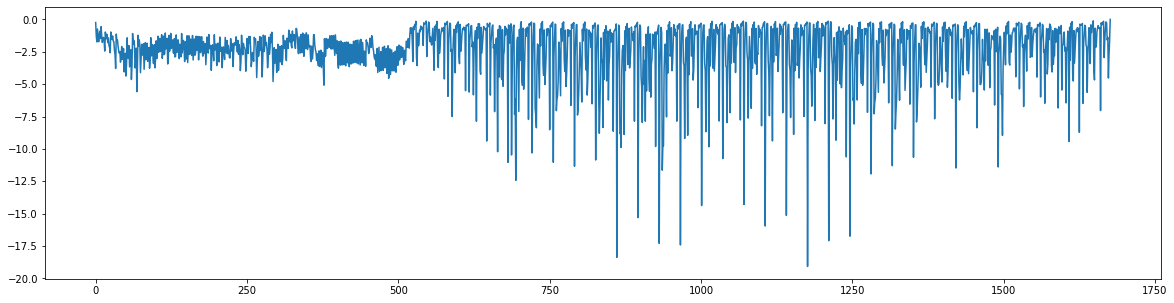

In [0]:
# Mesures minimales pour chaque observation du jeu de train
plt.figure(figsize=(20,5))
plt.plot(xtrain.min(axis=1))
plt.show()

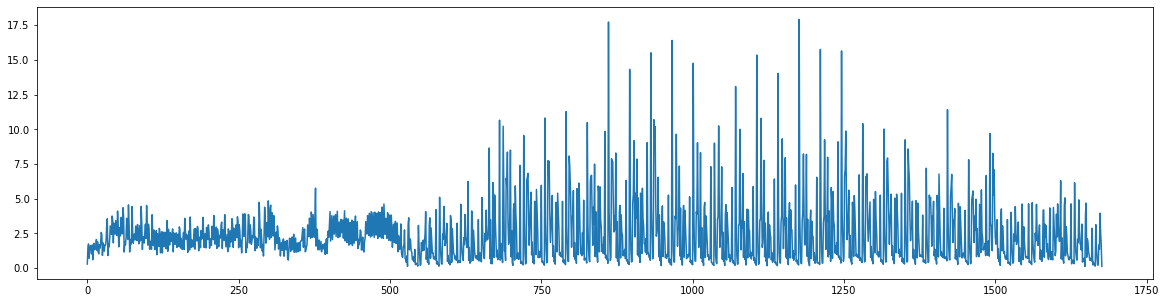

In [0]:
# Mesures maximales pour chaque observation du jeu de train
plt.figure(figsize=(20,5))
plt.plot(xtrain.max(axis=1))
plt.show()

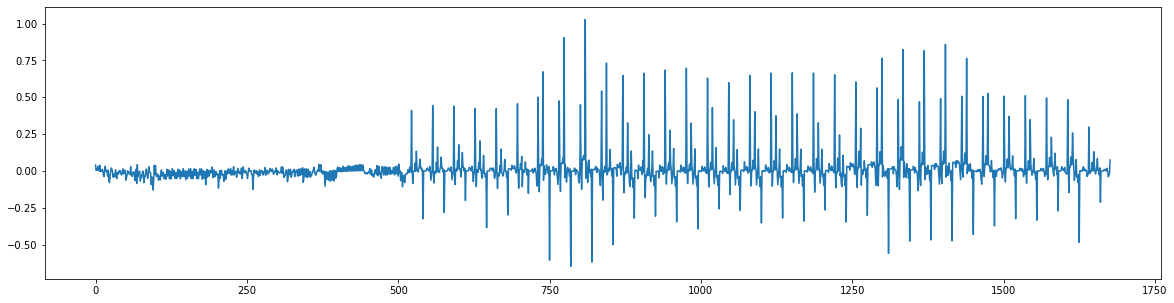

In [0]:
# Mesure moyenne pour chaque observation du jeu de train
plt.figure(figsize=(20,5))
plt.plot(xtrain.mean(axis=1))
plt.show()

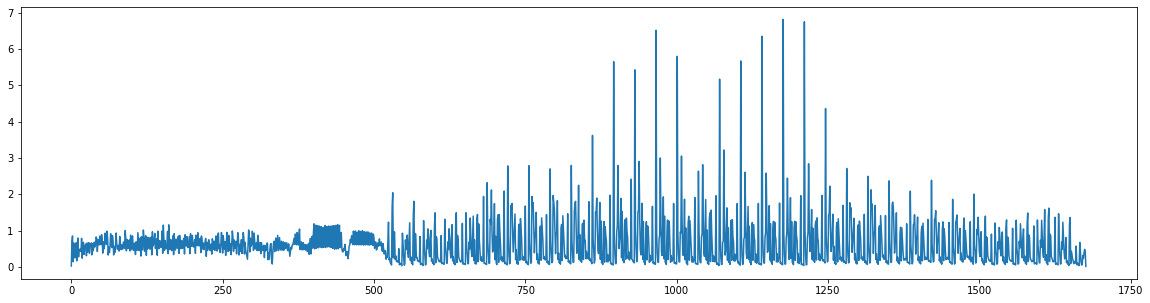

In [0]:
# Mesure std pour chaque observation du jeu de train
plt.figure(figsize=(20,5))
plt.plot(xtrain.std(axis=1))
plt.show()

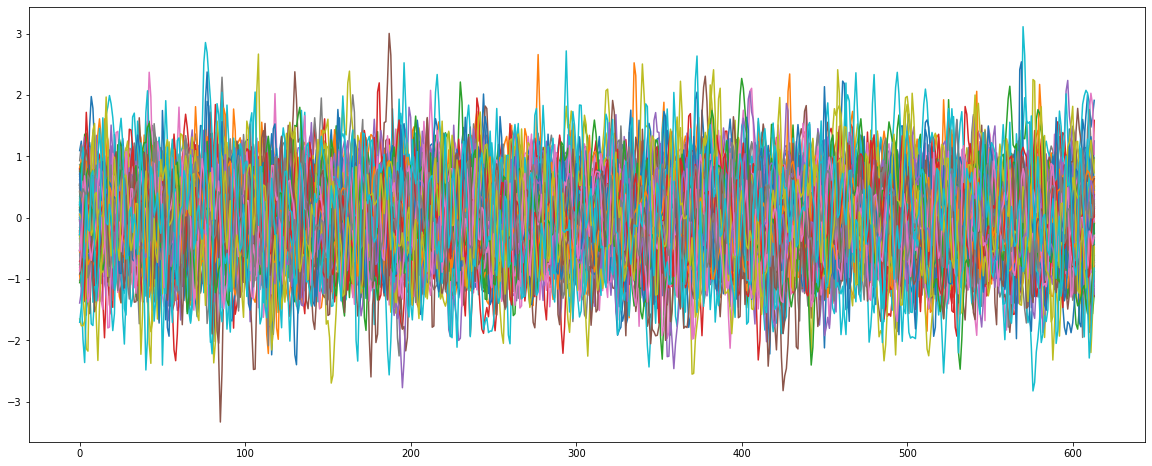

In [0]:
# Plot first 614 time points for first 100 observations
plt.figure(figsize=(20,8))
for i in range(100):
    plt.plot(range(614),xtrain[i,:614])
plt.show()

# Features extraction

## Tentative non retenue : Décomposition du signal en trend, season, residuals

In [0]:
def descomposition_signal(data):
  f=1024
  SEASON = []
  TREND = []
  RESIDUAL = []
  for i in range(0,len(data)):
    res = sm.tsa.seasonal_decompose(data[i], freq=f, extrapolate_trend='freq')
    SEASON.append(res.seasonal)
    TREND.append(res.trend)
    RESIDUAL.append(res.resid)
  return SEASON, TREND, RESIDUAL

train_season, train_trend, train_residual = descomposition_signal(xtrain)
test_season, test_trend, test_residual = descomposition_signal(xtest)


In [0]:
np.array(train_season).shape

(1677, 61440)

## Création de nouvelles features

### Features conservées

In [0]:
def stats_extraction(data):
  means = data.mean(axis=1)
  mins = data.min(axis=1)
  maxs = data.max(axis=1)
  stds = data.std(axis=1)
  vars = data.var(axis=1)
  medians = np.median(data, axis=1)
  per25 = np.percentile(data, q=25, axis=1)
  per75 = np.percentile(data, q=75, axis=1)
  return means, mins, stds, maxs, vars, medians, per25, per75

train_means, train_mins, train_stds, train_maxs, train_vars, train_medians, train_per25, train_per75 = stats_extraction(xtrain)
test_means, test_mins, test_stds, test_maxs, test_vars, test_medians, test_per25, test_per75 = stats_extraction(xtest)

In [0]:
def autocorr_extraction(data):
  data_t = data.transpose()
  OBS_COL = data_t.columns
  ACF1 = [] 
  ACF10 = []
  for col in OBS_COL:
    acf1 = data_t.iloc[:,int(col)].autocorr(lag=1)
    acf10 = data_t.iloc[:,int(col)].autocorr(lag=10)
    ACF1.append(acf1)
    ACF10.append(acf10)
  return ACF1, ACF10

train_acf1, train_acf10 = autocorr_extraction(X_train)
test_acf1, test_acf10 = autocorr_extraction(X_test)

In [0]:
def get_strengths(data):
  f=1024
  S_STRENGTH = []
  T_STRENGTH = []
  SP = []
  for i in range(0,len(data)):
    res = sm.tsa.seasonal_decompose(data[i], freq=f, extrapolate_trend='freq')
    season = res.seasonal
    trend = res.trend
    residual = res.resid
    strength_season = 1 - (residual.var() / (season + residual).var())
    strength_trend = 1 - (residual.var() / (trend + residual).var())
    S_STRENGTH.append(strength_season)
    T_STRENGTH.append(strength_trend)

    # Compute measure of spikiness
    n = len(data[i])
    d = (residual - np.nanmean(residual))**2
    varloo = (np.nanvar(residual)*(n-1)-d)/(n-2)
    spike = np.nanvar(varloo)
    SP.append(spike)
    #print(len(S_STRENGTH))
  return S_STRENGTH, T_STRENGTH, SP

train_S_STRENGTH, train_T_STRENGTH, train_sp = get_strengths(xtrain)
test_S_STRENGTH, test_T_STRENGTH, test_sp = get_strengths(xtrain)

In [0]:
def get_first_location_of_maximum_minimum(data):
  LOC_MAX = []
  LOC_MIN = []
  for i in range(0,(len(data)-1)):
    LOC_MAX.append(first_location_of_maximum(data[i]))
    LOC_MIN.append(first_location_of_minimum(data[i]))
  return LOC_MAX, LOC_MIN

train_LOC_MAX, train_LOC_MIN = get_first_location_of_maximum_minimum(xtrain)
test_LOC_MAX, test_LOC_MIN = get_first_location_of_maximum_minimum(xtest)

In [0]:
def get_c3(data):
  C3 = []
  for i in range(0,(len(data)-1)):
    C3.append(c3(data[i], lag=1))
  return C3

train_c3 = get_c3(xtrain)
test_c3 = get_c3(xtest)

In [0]:
def get_mean_second_derivative_central(data):
  DERIVATIVE = []
  for i in range(0,(len(data)-1)):
    DERIVATIVE.append(mean_second_derivative_central(data[i]))
  return DERIVATIVE

train_derivative = get_mean_second_derivative_central(xtrain)
test_derivative = get_mean_second_derivative_central(xtest)

In [0]:
def get_cid_ce(data, n):
  cid = []
  for i in range(0,(len(data)-1)):
    cid.append(cid_ce(data[i], n))
  return cid

train_cid = get_cid_ce(xtrain, 32)
test_cid= get_cid_ce(xtest, 32)

### Features non retenues

In [0]:
# from tsfeature in python
from statsmodels.tsa.stattools import acf

def acf_features(x):
    ### Unpacking series
    #(x, m) = x
    #if m is None:
        #m = 1
    size_x = len(x)

    acfx = acf(x, nlags = max(size_x, 10), fft=False)
    if size_x > 10:
        acfdiff1x = acf(np.diff(x, n = 1), nlags =  10, fft=False)
    else:
        acfdiff1x = [np.nan]*2

    if size_x > 11:
        acfdiff2x = acf(np.diff(x, n = 2), nlags =  10, fft=False)
    else:
        acfdiff2x = [np.nan]*2

    # first autocorrelation coefficient
    acf_1 = acfx[1]

    # sum of squares of first 10 autocorrelation coefficients
    sum_of_sq_acf10 = np.sum((acfx[:11])**2) if size_x > 10 else np.nan

    # first autocorrelation ciefficient of differenced series
    diff1_acf1 = acfdiff1x[1]

    # sum of squared of first 10 autocorrelation coefficients of differenced series
    diff1_acf10 = np.sum((acfdiff1x[:11])**2) if size_x > 10 else np.nan

    # first autocorrelation coefficient of twice-differenced series
    diff2_acf1 = acfdiff2x[1]

    # Sum of squared of first 10 autocorrelation coefficients of twice-differenced series
    diff2_acf10 = np.sum((acfdiff2x[:11])**2) if size_x > 11 else np.nan

    return acf_1, sum_of_sq_acf10, diff1_acf1, diff1_acf10, diff2_acf1, diff2_acf10
    

def get_acf_features(data):
  ACF = []
  for i in range(0,(len(data)-1)):
    ACF.append(acf_features(data[i]))
  return ACF

train_derivative = get_acf_features(xtrain)
test_derivative = get_acf_features(xtest)

In [0]:
def get_flats(data):
  flats = []
  for i in range(0,(len(data)-1)):
    cutx = pd.cut(data[i], bins=10, include_lowest=True, labels=False) + 1
    resx = np.array([sum(1 for i in g) for k,g in groupby(cutx)]).max()
    flats.append(resx)
  return flats

train_flats = get_flats(xtrain)
test_flats = get_flats(xtest)

In [0]:
def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False):    
    x = np.array(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se

def get_entropy(data):
  entro = []
  for i in range(0,(len(data)-1)):
    entro.append(spectral_entropy(data[i], sf=1024))
  return entro

train_entro= get_entropy(xtrain)
test_entro = get_entropy(xtest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [0]:
def get_number_crossing_m(data):
  crossing = []
  for i in range(0,(len(data)-1)):
    crossing.append(number_crossing_m(data[i], data[i].mean()))
  return crossing

train_crossing = get_number_crossing_m(xtrain)
test_crossing = get_number_crossing_m(xtest)

In [0]:
def get_percentage_of_reoccurring_datapoints_to_all_datapoints(data):
  reocc = []
  for i in range(0,(len(data)-1)):
    reocc.append(percentage_of_reoccurring_datapoints_to_all_datapoints(data[i]))
  return reocc

train_reocc = get_percentage_of_reoccurring_datapoints_to_all_datapoints(xtrain)
test_reocc= get_percentage_of_reoccurring_datapoints_to_all_datapoints(xtest)

In [0]:
def get_longest_strike_above_mean(data):
  STRIKE1 = []
  for i in range(0,(len(data)-1)):
    STRIKE1.append(longest_strike_above_mean(data[i]))
  return STRIKE1

train_STRIKE1 = get_longest_strike_above_mean(xtrain)
test_STRIKE1 = get_longest_strike_above_mean(xtest)

In [0]:
def get_zero_crossing_rate(data):
  ZERO_CROSS = []
  for i in range(0,(len(data)-1)):
    ZERO_CROSS.append(((data[i][:-1] * data[i][1:]) < 0).sum())
  return ZERO_CROSS

train_zeros = get_zero_crossing_rate(xtrain)
test_zeros = get_zero_crossing_rate(xtest)

In [0]:
def get_skewness(data):
  skew = []
  for i in range(0,(len(data)-1)):
    skew.append(skewness(data[i]))
  return skew

train_skewness = get_skewness(xtrain)
test_skewness= get_skewness(xtest)

### Concaténation des features

In [0]:
# Concaténation des features crées en un seul dataframe
xtrain_new_features = pd.DataFrame([train_means,
                                    train_mins,
                                    train_stds,
                                    train_maxs,
                                    train_vars,
                                    train_medians,
                                    train_per75,
                                    train_c3,
                                    train_acf1,
                                    #train_acf10,
                                    train_S_STRENGTH,
                                    train_T_STRENGTH,
                                    train_LOC_MAX,
                                    train_derivative, 
                                    #train_sp
                                    #train_flats
                                    #train_entro
                                    #train_stability,
                                    #train_lumpiness
                                    #train_kurt
                                    #train_crossing,
                                    #train_zeros,
                                    #train_STRIKE1,
                                    #train_reocc,
                                    #train_skewness, 
                                    #train_per25
                                    ]).transpose()

                                  
xtest_new_features = pd.DataFrame([test_means,
                                   test_mins,
                                   test_stds,
                                   test_maxs,
                                   test_vars,
                                   test_medians,
                                   test_per75,
                                   test_c3,
                                   test_acf1, 
                                   #test_acf10,
                                   test_S_STRENGTH, 
                                   test_T_STRENGTH, 
                                   test_LOC_MAX,
                                   test_derivative, 
                                   #test_sp
                                   #test_flats
                                   #test_entro
                                   #test_stability,
                                   #test_lumpiness
                                   #test_kurt
                                   #test_crossing,
                                   #test_zeros,
                                   #test_STRIKE1,
                                   #test_reocc,
                                   #test_skewness, 
                                   #test_per25
                                   ]).transpose()

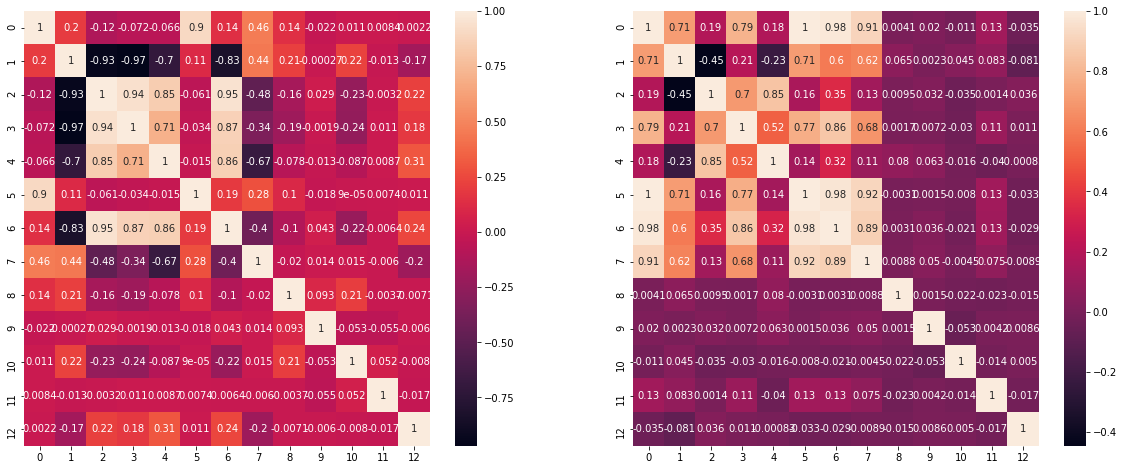

In [0]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sns.heatmap(xtrain_new_features.corr(), annot = True)
plt.subplot(122)
sns.heatmap(xtest_new_features.corr(), annot = True)

### Réduction de la matrice de nouvelles features (méthode non retenue)

In [0]:
#PCA transform sur la matrice new_features --> 10 components
#pca2 = PCA(n_components = 10, whiten = True)
#pca2.fit(xtrain_new_features)
#xtrain_fpca2 = pd.DataFrame(pca2.fit_transform(xtrain_new_features))
#xtest_fpca2 = pd.DataFrame(pca2.fit_transform(xtest_new_features))

## Réduction de dimension

## Tentative non retenue : décomposition en ondelettes

In [0]:
def transform_wavelates(data):
  DATA1 = []
  DATA2 = []
  for i in range(0,(len(data)-1)):
    data1, data2 = pywt.dwt(data[i], 'db1')
    DATA1.append(data1)
    DATA2.append(data2)
  return DATA1, DATA2 

xtrain_wave1, xtrain_wave2 = transform_wavelates(xtrain)

In [0]:
np.array(xtrain_wave1).shape

(1676, 30720)

## Tentative non retenue : Auto Encodeur

In [0]:
# reduce to 10 features
encoding_dim = 512
encoding_dim2 = 10

input_df = Input(shape=(61440,))
encoded = Dense(encoding_dim, activation='relu')(input_df)
encoded2 = Dense(encoding_dim2, activation='relu')(encoded)
decoded1 = Dense(encoding_dim, activation='sigmoid')(encoded2)
decoded = Dense(61440, activation='sigmoid')(encoded)

# encoder
autoencoder = Model(input_df, decoded)

# intermediate result
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(xtrain, xtrain,
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(xtest, xtest))

## Réductions de dimensions par moyennes et PCA

In [0]:
def reduction_matrice(data, fenetre=32):
  # Fonction qui calcule la moyenne et la variance de colonnes sur des fenêtres de 32 snapshots
  # Ceci permet de réduire la matrice initiale
    index_debut = 0
    index_fin = fenetre
    data_reducted_mean = np.empty((data.shape[0],data.shape[1]//fenetre))
    data_reducted_var = np.empty((data.shape[0],data.shape[1]//fenetre))
    for i in range(data.shape[1]//fenetre):
        data_reducted_mean[:,i] = np.mean((data[:,index_debut:index_fin]), axis=1)
        data_reducted_var[:,i] = np.var((data[:,index_debut:index_fin]), axis=1)
        index_debut = index_fin
        index_fin += fenetre
    return pd.DataFrame(data_reducted_mean), pd.DataFrame(data_reducted_var)

train_prep_mean, train_prep_var = reduction_matrice(xtrain)
test_prep_mean, test_prep_var = reduction_matrice(xtest)

In [0]:
# calcul de nouvelles features, qui n'ont pas été retenues
#train_stability = train_prep_mean.var(axis=1)
#test_stability = test_prep_mean.var(axis=1)

In [0]:
# calcul de nouvelles features, qui n'ont pas été retenues
#train_lumpiness = train_prep_var.var(axis=1)
#test_lumpiness = test_prep_var.var(axis=1)

In [0]:
#PCA transform sur la matrice réduite --> 10 components
pca = PCA(n_components = 10, whiten = True)
pca.fit(train_prep_mean)
xtrain_fpca = pca.fit_transform(train_prep_mean)
xtest_fpca = pca.fit_transform(test_prep_mean)

In [0]:
xtest_fpca.shape

(2511, 10)

## Préparation du dataset de train et test

Concaténation de la matrice réduite avec les nouvelles features 

In [0]:
COL = xtest_new_features.columns
for col in COL:
  xtest_new_features[col].fillna(xtest_new_features[col].mean(), inplace=True)
  xtrain_new_features[col].fillna(xtrain_new_features[col].mean(), inplace=True)
  #print(col)

# Concaténation des features crées et du résultat de la PCA en un seul dataframe
X_train_final = pd.concat([pd.DataFrame(xtrain_fpca),xtrain_new_features], axis = 1) #xtrain_new_features
X_test_final = pd.concat([pd.DataFrame(xtest_fpca),xtest_new_features], axis = 1) #xtest_new_features

# Modèles de outliers detection

## LOF (non retenu)

In [0]:
# Fit the low-dimensional method
lof = LocalOutlierFactor(n_neighbors = 2 ,contamination = 'auto', novelty = True)
lof.fit(X_train_final)

# Calculate anomaly score on the (PCA-transformed) test data
lof_scores = -lof.score_samples(X_test_final)
print(lof_scores[:100])

[  2.60335744   1.14041487   1.04711484   0.99030228   1.36558323
   1.09045697   1.0084258    1.09509912   0.99639903   1.93938082
   0.97722578   1.41271401   0.99490201   1.10192077   1.03933326
   1.           1.           1.48340799   0.96919991   0.92472127
   1.3158282    0.97555336   1.49358704   1.12309876 301.19815432
   1.99756698   1.11360218   1.0931467    1.09707634   1.06444431
   0.99604745   1.01495323   1.33438812   1.34473728   1.45030277
   1.04007753   1.13384067 176.23052517   1.02503413   1.65746359
   1.02904828   1.           1.06350551   1.81318781   1.49033759
   1.14105179   1.21176908   1.           1.26138597   1.10140998
   1.03114103   1.1547915    1.19391666   1.02762541   2.08961285
   1.06645422   1.4278155    1.26783522   2.1607511    1.06846065
   1.00413991   1.12957348   1.02796451   1.1686499    1.29575527
   1.62087085   1.57883645   1.03649946   1.1313525    1.22034794
 570.84511364   0.93317583   1.02900874   1.03627168   1.23334934
   1.02323

## Isolation Forest (non retenu)

In [0]:
# Fit the low-dimensional method
forest = IsolationForest(n_estimators=500,n_jobs=-1,random_state=0, contamination='auto')
forest.fit(X_train_final)

# Calculate anomaly score on the (PCA-transformed) test data
forest_scores = -forest.score_samples(X_test_final)
print(forest_scores[:100])

[0.36071555 0.35134164 0.37144336 0.34666488 0.3418348  0.34598825
 0.34788984 0.36016787 0.33989205 0.58231022 0.35003864 0.3416207
 0.35144018 0.34899899 0.35141656 0.33599713 0.34314944 0.36153666
 0.34345435 0.38730609 0.39157345 0.34186793 0.34552371 0.33338787
 0.70815839 0.35252845 0.34729624 0.34666679 0.34700688 0.36399726
 0.34037562 0.34264305 0.34741009 0.35039087 0.34933237 0.35021552
 0.354338   0.6841719  0.34421443 0.45968821 0.34303005 0.34639785
 0.34119999 0.34678324 0.35610382 0.35397744 0.51314299 0.34026034
 0.40220344 0.48429464 0.34091322 0.34169315 0.35328476 0.34950628
 0.56007851 0.33767766 0.33704138 0.35813327 0.36421401 0.34650709
 0.35298083 0.35439037 0.3437258  0.34852437 0.34671778 0.33919185
 0.36072625 0.35354759 0.37230085 0.40155646 0.71197417 0.35021952
 0.34392611 0.32992454 0.48647633 0.34277848 0.35169801 0.34023203
 0.33767605 0.33716494 0.33466492 0.36544575 0.40854139 0.34704497
 0.34761934 0.37018436 0.34972195 0.34851519 0.38124225 0.39249

## Bagging LOF

In [0]:
# train Feature Bagging detector
FeatureBag = FeatureBagging(check_estimator=False, n_estimators=500, bootstrap_features=True, combination='average', max_features=1.0)
FeatureBag.fit(X_train_final)

# get the prediction on the test data
y_test_pred = FeatureBag.predict(X_test_final)  # outlier labels (0 or 1)
y_test_scores = FeatureBag.decision_function(X_test_final)  # outlier scores
print(y_test_scores[:100])

[  2.36424681   1.3997808    1.06039981   1.56022811   1.160288
   1.2139291    1.01817146   1.03034036   1.18821344   1.40333819
   1.04484397   1.16938302   1.26491637   1.54988558   1.19475898
   1.25884198   1.25924459   1.5912221    1.3026878    1.40057774
   1.01810062   1.17609908   1.14996042   1.02176479 120.08073245
   1.18952943   1.38753917   1.23974603   0.99151898   1.52709694
   1.2514905    1.18784218   1.21574295   1.21684628   1.41138143
   1.01296699   1.31188311  70.17472772   1.01599512   1.18566541
   1.01662108   1.14899059   1.00946026   1.8584692    1.4463083
   1.39177031   1.13226111   1.01261394   1.09946176   1.08459327
   1.2214474    0.99835509   1.48627603   1.31966813   1.72854709
   1.19037563   1.12690174   1.84031428   1.21464637   1.28459026
   1.67942329   1.02665871   1.0021914    1.23556225   1.29285709
   1.24715262   2.0841015    1.34543921   1.04035151   1.07084342
 227.14445194   1.22323836   1.04551264   0.99142194   1.11142564
   1.00771641

## Moyenne des scores des modèles (non retenu)

In [0]:
scores_final = (forest_scores + y_test_scores)/2

In [0]:
print(scores_final[:100])

[  1.40173265   0.81471645   0.71673163   0.89932314   0.71377549
   0.74205982   0.68555242   0.68901418   0.74688253   0.91989709
   0.69528291   0.73009908   0.78030555   0.85340302   0.75937425
   0.73388502   0.75225576   1.00271321   0.7825956    0.82179879
   0.70493233   0.71847585   0.71953708   0.67539602  69.0762601
   0.75501929   0.83084349   0.76232193   0.67007592   0.88885733
   0.7483122    0.72234183   0.78619002   0.74818135   0.85686976
   0.67849612   0.80026353  40.73483888   0.67264715   0.81321483
   0.67672294   0.72012032   0.67140083   1.00468192   0.86484018
   0.82144189   0.77089375   0.67445666   0.7622666    0.73740032
   0.7452667    0.66804062   0.85440668   0.82138849   1.10618457
   0.69987875   0.68740216   1.14108719   0.75531427   0.75382599
   0.95583718   0.68893085   0.66778998   0.75245068   0.77997343
   0.72617122   1.21260389   0.78814308   0.69341692   0.7414231
 129.84184248   0.75830331   0.6917543    0.65815656   0.76178179
   0.6734120

# Soumissions

In [0]:
# Save the anomaly scores to file
print(y_test_scores.shape)
np.savetxt('/content/gdrive/My Drive/TELECOM_MS/TELECOM/P3/MDI341/data_challenge/ytest_soumissions/ytest_challenge_2.csv', y_test_scores, fmt = '%1.6f', delimiter=',')

(2511,)
